In [1]:
import torch
import sys


from Transformer.Model1D import DiT1D
from Transformer.Noise import Noise as NoiseDiT

from Unet.Noise import Noise as NoiseU
from Unet.Model import Unet1D

from UnetAttn.Noise import Noise as NoiseUA
from UnetAttn.Model1D import UNet1DAttn



from matplotlib import pyplot as plt


In [2]:
def rescale_tensor(x, new_min, new_max):

    current_min = x.min()
    current_max = x.max()
    
    normalized_x = (x - current_min) / (current_max - current_min)
    
    rescaled_x = normalized_x * (new_max - new_min) + new_min
    return rescaled_x

In [3]:
class NoiseScheduler():
    def __init__(self, Noise, model):
        self.obj = Noise(T = 300, start=0.0001, end=0.02)
        self.T = 300
        self.model = model
        
    @torch.no_grad()
    def sample_timestep(self, x, t):

        betas_t = self.obj.get_index_from_list(self.obj.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.obj.get_index_from_list(self.obj.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = self.obj.get_index_from_list(self.obj.sqrt_recip_alphas, t, x.shape)
        
        pred = self.model(x, t)
        mu = sqrt_recip_alphas_t * (x - betas_t * pred / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = self.obj.get_index_from_list(self.obj.posterior_variance, t, x.shape)
        
        if t == 0:
            return mu
        else:
            noise = torch.randn_like(x)
            return mu + torch.sqrt(posterior_variance_t) * noise 

    @torch.no_grad()
    def sample_plot_image(self, ):
        img = torch.randn((16, 1, 256), device='cuda')
        plt.figure(figsize=(20,1))
        plt.axis('off')
        num_images = 10
        stepsize = int(self.T/num_images)

        for i in range(0,self.T)[::-1]:
            t = torch.full((1,), i, device='cuda', dtype=torch.long)
            img = self.sample_timestep(img, t)

            img = torch.clamp(img, -1.0, 1.0)
            if i % stepsize == 0:
                plt.subplot(1, num_images, int(i/stepsize)+1)
                plt.plot(img.detach().cpu()[0].squeeze(0))
        plt.show()
        return img       

Num params:  18664321


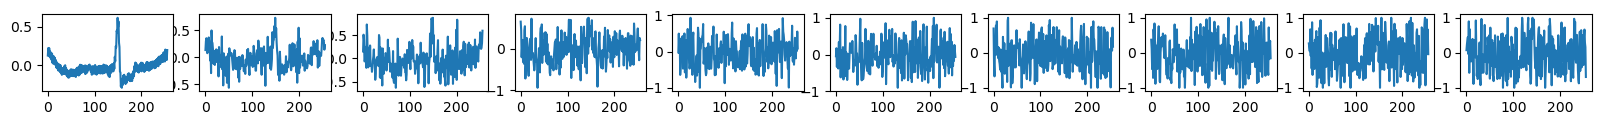

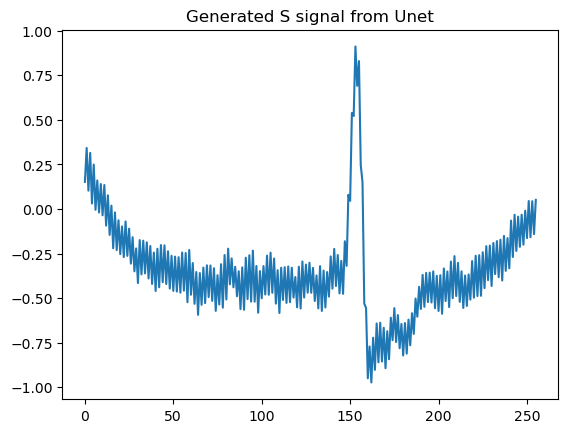

In [8]:
# UNet

model = Unet1D()
print("Num params: ", sum(p.numel() for p in model.parameters()))

path = 'weights/unet/weights.pth'
model.load_state_dict(torch.load(path, weights_only=True))
model.to('cuda')

noise = NoiseScheduler(NoiseU, model)

pred_signals = noise.sample_plot_image()
pred_img = rescale_tensor(pred_signals, -1, 1)

plt.figure()
plt.plot(pred_img[4].detach().cpu().squeeze(1).transpose(0,1))
plt.title("Generated S signal from Unet")
plt.show()

Num params:  20059845


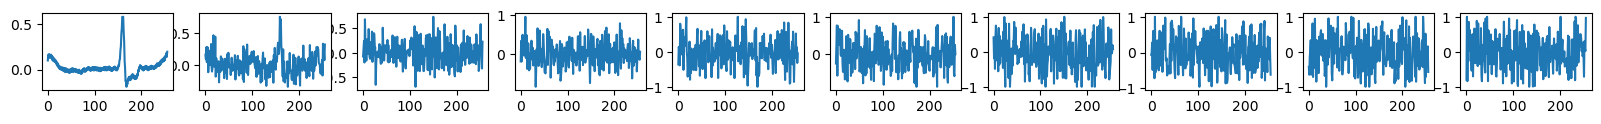

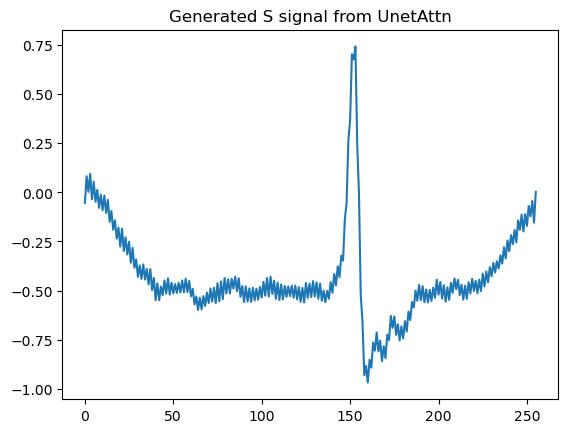

In [5]:
# UNetAttn

model = UNet1DAttn()
print("Num params: ", sum(p.numel() for p in model.parameters()))

path = 'weights/unetattn/weights.pth'
model.load_state_dict(torch.load(path, weights_only=True))
model.to('cuda')

noise = NoiseScheduler(NoiseUA, model)

pred_signals = noise.sample_plot_image()
pred_img = rescale_tensor(pred_signals, -1, 1)

plt.figure()
plt.plot(pred_img[4].detach().cpu().squeeze(1).transpose(0,1))
plt.title("Generated S signal from UnetAttn")
plt.show()

Num params:  6606596


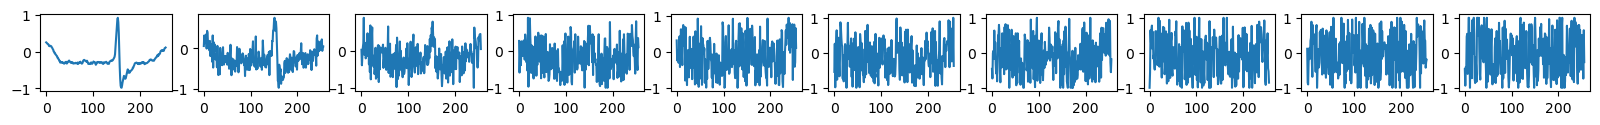

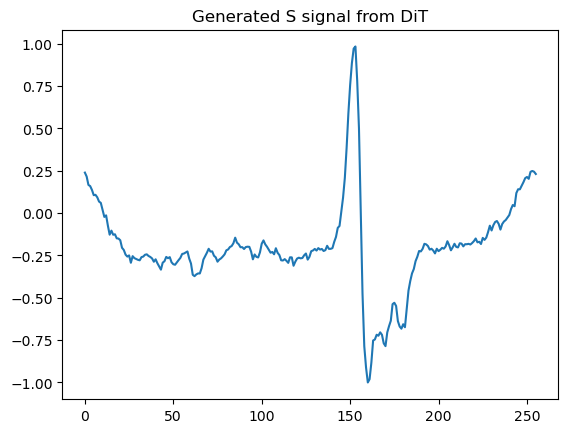

In [6]:
# DiT

model = DiT1D(patch_size=4, signal_length = 256, embed_dim = 256,  hidden_dim=256)
print("Num params: ", sum(p.numel() for p in model.parameters()))

path = 'weights/dit/weights.pth'
model.load_state_dict(torch.load(path, weights_only=True))
model.to('cuda')

noise = NoiseScheduler(NoiseDiT, model)

pred_signals = noise.sample_plot_image()
pred_img = rescale_tensor(pred_signals, -1, 1)

plt.figure()
plt.plot(pred_img[4].detach().cpu().squeeze(1).transpose(0,1))
plt.title("Generated S signal from DiT")
plt.show()